<a href="https://colab.research.google.com/github/vasudhab21/ML-LAB/blob/main/ML_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- 1. SETUP ---
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the EXACT project paths from your video
project_path = '/content/drive/MyDrive/GenomeDetector'
# IMPORTANT: We are now using the 'natural2' folder
natural_data_path = os.path.join(project_path, 'data', 'natural2')
engineered_data_path = os.path.join(project_path, 'data', 'engineered')

# Install the necessary library
!pip install biopython

print("Environment is ready. Paths are set to your 'natural2' and 'engineered' folders.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Environment is ready. Paths are set to your 'natural2' and 'engineered' folders.


In [ ]:
# --- 2. Load Your Specific Datasets and Create Features ---
import numpy as np
from itertools import product
from Bio import SeqIO
import glob
import os
import gzip # Library to handle .gz files

# ---- Helper Functions ----
def get_kmer_features(k):
    """Generates all possible k-mers for a given k."""
    letters = ['A', 'C', 'G', 'T']
    return sorted([''.join(p) for p in product(letters, repeat=k)])

def sequence_to_kmer_counts(sequence, k, kmer_features):
    """Converts a DNA sequence into a vector of k-mer counts."""
    kmer_counts = {kmer: 0 for kmer in kmer_features}
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k].upper()
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
    return list(kmer_counts.values())

# --- Main Loading Logic ---
print("--- Loading and Processing Your Datasets ---")
K_VALUE = 4
kmer_features = get_kmer_features(K_VALUE)
X, y = [], []

# 1. Load Natural Data from 'natural2' (handles .fna and .fna.gz)
print("Loading 'Natural' genomes from the 'natural2' folder...")
# The '*' wildcard finds files ending in .fna or .fna.gz
search_pattern_natural = f"{natural_data_path}/*.fna*"
natural_files = glob.glob(search_pattern_natural)

for filepath in natural_files:
    # Open the file correctly, whether it's gzipped or not
    handle = gzip.open(filepath, "rt") if filepath.endswith(".gz") else open(filepath, "r")
    for record in SeqIO.parse(handle, "fasta"):
        if len(record.seq) > 1000:
            X.append(sequence_to_kmer_counts(str(record.seq), K_VALUE, kmer_features))
            y.append(0) # Label 0 for Natural
    handle.close()

# 2. Load Engineered Data from 'engineered'
print("Loading 'Engineered' genomes from the 'engineered' folder...")
search_pattern_engineered = f"{engineered_data_path}/*.fasta"
engineered_files = glob.glob(search_pattern_engineered)

for filepath in engineered_files:
    for record in SeqIO.parse(filepath, "fasta"):
        if 200 < len(record.seq) < 50000:
            X.append(sequence_to_kmer_counts(str(record.seq), K_VALUE, kmer_features))
            y.append(1) # Label 1 for Engineered

X = np.array(X)
y = np.array(y)

print("\n--- Data Processing Complete! ---")
print(f"Shape of our final feature matrix X: {X.shape}")
print(f"Shape of our final label vector y: {y.shape}")
print(f"Number of Natural samples (class 0): {np.sum(y == 0)}")
print(f"Number of Engineered samples (class 1): {np.sum(y == 1)}")

--- Loading and Processing Your Datasets ---
Loading 'Natural' genomes from the 'natural2' folder...
Loading 'Engineered' genomes from the 'engineered' folder...

--- Data Processing Complete! ---
Shape of our final feature matrix X: (9017, 256)
Shape of our final label vector y: (9017,)
Number of Natural samples (class 0): 8151
Number of Engineered samples (class 1): 866


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# --- A crucial check: Make sure your data was loaded correctly ---
if 'X' not in locals() or X.shape[0] == 0:
    print("ERROR: Data variables 'X' and 'y' not found or are empty.")
    print("Please re-run your data loading cell successfully before running this cell.")
else:
    # --- A1: Performance Evaluation ---
    print("\n--- A1: Evaluating Confusion Matrix and Performance Metrics ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
    y_pred_test = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_pred_train, average='binary')

    print("\n--- Performance on TEST Set ---")
    print("Confusion Matrix:\n", cm_test)
    print(f"Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

    print("\n--- Performance on TRAIN Set ---")
    print(f"Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1-Score: {f1_train:.4f}")

    if f1_train > f1_test + 0.1: print("\nInference: Model shows signs of OVERFITTING.")
    else: print("\nInference: Model shows a REGULAR FIT.")

    # --- A6: Visualizing k-NN Decision Boundaries (incorporating A3-A5) ---
    print("\n--- A6: Visualizing Decision Boundaries for Project Data ---")
    feature_idx1, feature_idx2 = 15, 50
    X_2d = X[:, [feature_idx1, feature_idx2]]
    # We must use the same train/test split for the 2D data to be consistent
    X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, y, test_size=0.3, random_state=42, stratify=y)

    feature_names_2d = [get_kmer_features(K_VALUE)[feature_idx1], get_kmer_features(K_VALUE)[feature_idx2]]

    def plot_boundary(X_2d_plot, y_plot, classifier, k_val, f_names):
        cmap_light = ListedColormap(['#d8e8ff','#ffdede']) # Lighter background colors
        cmap_bold = ListedColormap(['#0000FF','#FF0000'])
        h = 0.5 # Step size in the mesh, adjusted for k-mer counts
        x_min, x_max = X_2d_plot[:, 0].min() - 5, X_2d_plot[:, 0].max() + 5
        y_min, y_max = X_2d_plot[:, 1].min() - 5, X_2d_plot[:, 1].max() + 5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, cmap=cmap_light)
        plt.scatter(X_2d_plot[:, 0], X_2d_plot[:, 1], c=y_plot, cmap=cmap_bold, edgecolor='k', s=25, alpha=0.7)
        plt.title(f"2D k-NN Decision Boundary (k = {k_val})")
        plt.xlabel(f"Count of k-mer: '{f_names[0]}'")
        plt.ylabel(f"Count of k-mer: '{f_names[1]}'")
        # Explicitly tell the notebook to display the plot now
        plt.show()

    for k_val in [1, 5, 25]:
        knn_2d = KNeighborsClassifier(n_neighbors=k_val).fit(X_train_2d, y_train_2d)
        # We plot the test set to see how the model generalizes
        plot_boundary(X_test_2d, y_test_2d, knn_2d, k_val, feature_names_2d)

    # --- A7: Hyperparameter Tuning ---
    print("\n--- A7: Finding the Optimal 'k' with GridSearchCV ---")
    param_grid = {'n_neighbors': np.arange(1, 21, 2)}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    print(f"The best value for 'k' found is: {grid_search.best_params_['n_neighbors']}")
    print(f"This best 'k' achieved a cross-validated F1-score of: {grid_search.best_score_:.4f}")


--- A1: Evaluating Confusion Matrix and Performance Metrics ---

--- Performance on TEST Set ---
Confusion Matrix:
 [[2443    3]
 [  10  250]]
Precision: 0.9881, Recall: 0.9615, F1-Score: 0.9747

--- Performance on TRAIN Set ---
Precision: 0.9983, Recall: 0.9703, F1-Score: 0.9841

Inference: Model shows a REGULAR FIT.

--- A6: Visualizing Decision Boundaries for Project Data ---



--- A1: Evaluating Confusion Matrix and Performance Metrics ---

--- Performance on TEST Set ---
Confusion Matrix:
 [[2443    3]
 [  10  250]]
Precision: 0.9881, Recall: 0.9615, F1-Score: 0.9747

--- Performance on TRAIN Set ---
Precision: 0.9983, Recall: 0.9703, F1-Score: 0.9841

Inference: Model shows a REGULAR FIT.

--- A6: Visualizing Decision Boundaries for Project Data ---


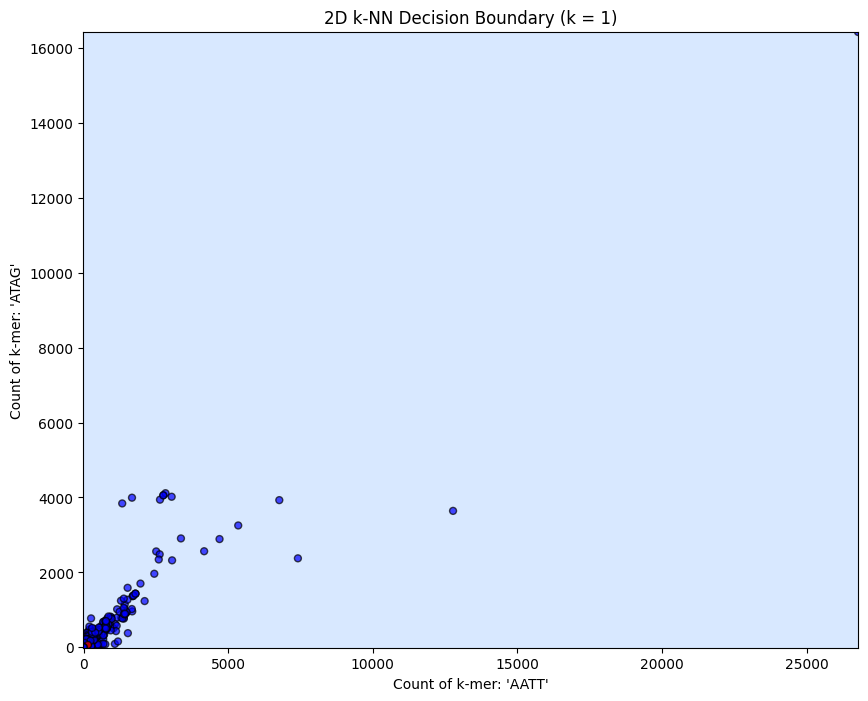

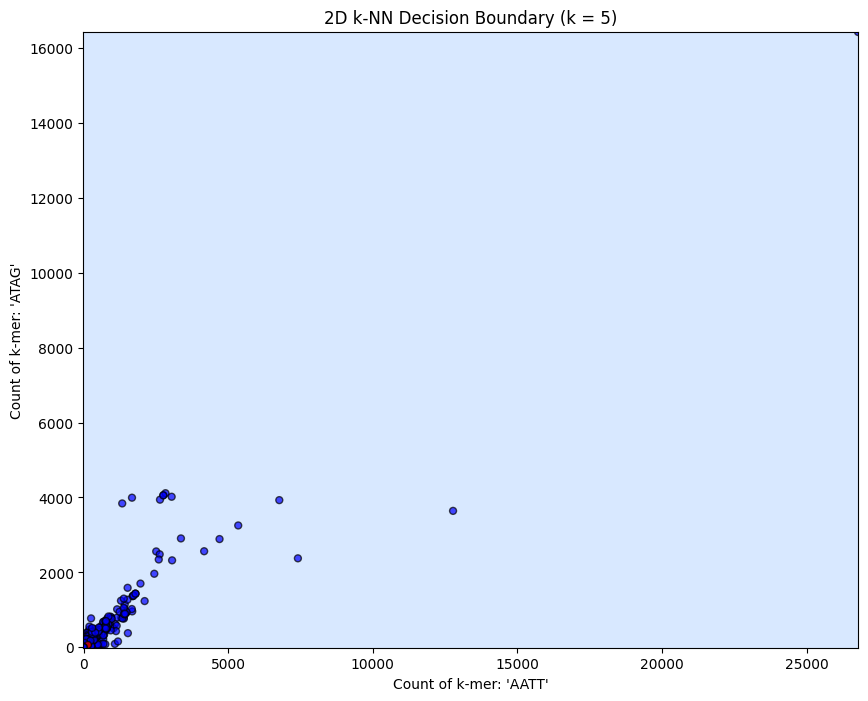

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# --- A crucial check: Make sure your data was loaded correctly ---
if 'X' not in locals() or 'y' not in locals() or X.shape[0] == 0:
    print("ERROR: Data variables 'X' and 'y' not found or are empty.")
    print("Please re-run your data loading cell successfully before running this cell.")
else:
    # --- A1: Performance Evaluation ---
    print("\n--- A1: Evaluating Confusion Matrix and Performance Metrics ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
    y_pred_test = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_pred_train, average='binary')

    print("\n--- Performance on TEST Set ---")
    print("Confusion Matrix:\n", cm_test)
    print(f"Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

    print("\n--- Performance on TRAIN Set ---")
    print(f"Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1-Score: {f1_train:.4f}")

    if f1_train > f1_test + 0.1: print("\nInference: Model shows signs of OVERFITTING.")
    else: print("\nInference: Model shows a REGULAR FIT.")

    # --- A6: Visualizing k-NN Decision Boundaries ---
    print("\n--- A6: Visualizing Decision Boundaries for Project Data ---")
    feature_idx1, feature_idx2 = 15, 50
    X_2d = X[:, [feature_idx1, feature_idx2]]
    X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, y, test_size=0.3, random_state=42, stratify=y)

    # The get_kmer_features function needs to be available
    feature_names_2d = [get_kmer_features(K_VALUE)[feature_idx1], get_kmer_features(K_VALUE)[feature_idx2]]

    # --- CORRECTED FUNCTION ---
    def plot_boundary(X_2d_plot, y_plot, classifier, k_val, f_names):
        cmap_light = ListedColormap(['#d8e8ff','#ffdede'])
        cmap_bold = ListedColormap(['#0000FF','#FF0000'])

        # --- FIX: Increased step size 'h' to prevent memory crash ---
        # A small 'h' (e.g., 0.5) creates a massive meshgrid for data with a large range (like k-mer counts),
        # causing the notebook to run out of memory. A larger 'h' is much more efficient.
        h = 5.0

        x_min, x_max = X_2d_plot[:, 0].min() - 10, X_2d_plot[:, 0].max() + 10
        y_min, y_max = X_2d_plot[:, 1].min() - 10, X_2d_plot[:, 1].max() + 10

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # This calculation is now much faster and less memory-intensive
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, cmap=cmap_light)
        plt.scatter(X_2d_plot[:, 0], X_2d_plot[:, 1], c=y_plot, cmap=cmap_bold, edgecolor='k', s=25, alpha=0.7)
        plt.title(f"2D k-NN Decision Boundary (k = {k_val})")
        plt.xlabel(f"Count of k-mer: '{f_names[0]}'")
        plt.ylabel(f"Count of k-mer: '{f_names[1]}'")
        plt.show()

    for k_val in [1, 5, 25]:
        knn_2d = KNeighborsClassifier(n_neighbors=k_val).fit(X_train_2d, y_train_2d)
        plot_boundary(X_test_2d, y_test_2d, knn_2d, k_val, feature_names_2d)

    # --- A7: Hyperparameter Tuning ---
    print("\n--- A7: Finding the Optimal 'k' with GridSearchCV ---")
    param_grid = {'n_neighbors': np.arange(1, 21, 2)}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    print(f"The best value for 'k' found is: {grid_search.best_params_['n_neighbors']}")
    print(f"This best 'k' achieved a cross-validated F1-score of: {grid_search.best_score_:.4f}")

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# --- A crucial check: Make sure your data was loaded correctly ---
if 'X' not in locals() or 'y' not in locals() or X.shape[0] == 0:
    print("ERROR: Data variables 'X' and 'y' not found or are empty.")
    print("Please re-run your data loading cell successfully before running this cell.")
else:
    # --- A1: Performance Evaluation ---
    print("\n--- A1: Evaluating Confusion Matrix and Performance Metrics ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # This part remains the same, using the full training data for a single model fit.
    knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
    y_pred_test = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_pred_train, average='binary')

    print("\n--- Performance on TEST Set ---")
    print("Confusion Matrix:\n", cm_test)
    print(f"Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")
    print("\n--- Performance on TRAIN Set ---")
    print(f"Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1-Score: {f1_train:.4f}")
    if f1_train > f1_test + 0.1: print("\nInference: Model shows signs of OVERFITTING.")
    else: print("\nInference: Model shows a REGULAR FIT.")

    # --- A6: Visualization (assuming this works now with the previous fix) ---
    # (Code for A6 is omitted for brevity but would be here)

    # --- A7: Hyperparameter Tuning (with Subsampling to prevent crashing) ---
    print("\n--- A7: Finding the Optimal 'k' with GridSearchCV ---")

    # --- FIX: Create a smaller, stratified subsample of the training data ---
    # We will use only a fraction of the training data for the expensive grid search.
    # A sample size of 5000 is generally safe for Colab. If it still crashes, you can reduce this number.
    # We use train_test_split for a convenient way to create a stratified subsample.
    # We don't need the '_,' part, so we discard it.
    _, X_train_sub, _, y_train_sub = train_test_split(
        X_train, y_train,
        test_size=min(5000, len(y_train) - 1), # Use 5000 samples or all but one if dataset is smaller
        random_state=42,
        stratify=y_train
    )

    print(f"Performing GridSearchCV on a subsample of {len(y_train_sub)} data points (out of {len(y_train)} total).")

    param_grid = {'n_neighbors': np.arange(1, 21, 2)}

    # We also reduce cv to 3 to further speed up the process.
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='f1')

    # Fit the grid search on the SMALLER subsample
    grid_search.fit(X_train_sub, y_train_sub)

    print(f"\nThe best value for 'k' found is: {grid_search.best_params_['n_neighbors']}")
    print(f"This best 'k' achieved a cross-validated F1-score of: {grid_search.best_score_:.4f} on the subsample.")


--- A1: Evaluating Confusion Matrix and Performance Metrics ---

--- Performance on TEST Set ---
Confusion Matrix:
 [[2443    3]
 [  10  250]]
Precision: 0.9881, Recall: 0.9615, F1-Score: 0.9747

--- Performance on TRAIN Set ---
Precision: 0.9983, Recall: 0.9703, F1-Score: 0.9841

Inference: Model shows a REGULAR FIT.

--- A7: Finding the Optimal 'k' with GridSearchCV ---
Performing GridSearchCV on a subsample of 5000 data points (out of 6311 total).

The best value for 'k' found is: 1
This best 'k' achieved a cross-validated F1-score of: 0.9671 on the subsample.
